In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
%autosave 0 

Autosave disabled


In [25]:


class HMM (object):
             def __init__(self,A,B,PI):
                 self.A=A
                 self.B=B
                 self.PI=PI   
def viterbi(obs,Modelo1,PI):
    
    delta=np.zeros((len(obs)+1,len(Modelo1.A)))
    phi=np.zeros((len(obs)+1,len(A)))+666
    path =np.zeros(len(obs)+1)
    T=len(obs)
    Modelo1.PI = PI
    delta[0,:]= Modelo1.PI * Modelo1.B[:,obs[0]]
    phi[0,:]=666
    for t in range(len(obs)):
        for j in range(delta.shape[1]):

            delta [t+1,j]=np.max(delta[t] * A[:,j]) * B[j,obs[t]]
            phi[t+1,j]= np.argmax(delta[t] * A[:,j])
    path[T]=int(np.argmax(delta[T,:]))
    for i in np.arange(T-1,0,-1):
        #print (i,phi[i+1,int(path[i+1])])
        path[i]=phi[i+1,int(path[i+1])]
    return(path)
def cuantizar_xy(xy, cc):
    xycuant=cc
    out=np.power(xycuant-xy,2).sum(axis=1).argmin()
    return out
    
def path_to_xy(path,ccxy):
    estimated= pd.DataFrame(path.astype(int).T)
    estimated.columns=[['Path_vit']]
    estimated['xcuant'] = estimated['Path_vit'].apply(lambda x: ccxy[x,0])
    estimated['ycuant'] = estimated['Path_vit'].apply(lambda x: ccxy[x,1])                                
    return (estimated)
def quantized(xyth,ccxyth):
    xythcuant=np.argmin(np.linalg.norm(xyth-ccxyth,axis=1))
    x,y=ccxyth[xythcuant,:2]
    return ((x,y),(xythcuant))



In [26]:
def Markov_A_2_grafo(A,ccxyth):
    dists=np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range (A.shape[1]):
            if A[i,j]!=0 :
                dists[i,j]= np.linalg.norm(ccxyth[i]-ccxyth[j])    
    
    
    con = np.where(dists==0,np.inf,dists)
    graphe2=grafo(ccxyth,con)
    return graphe2


class node(object):
    def __init__(self,x,y):
        self.x=x
        self.y=y
        
        
class grafo (object):
             def __init__(self,nodos,conec):
                 self.nodos=nodos
                 self.conec=conec        

def dijkstra(nodoinicial,nodofinal,graphe):
    

    numnodos= len(graphe.nodos)
    con = graphe.conec
    D= np.ones(numnodos)*np.inf
    Prv= np.ones(numnodos)*np.inf
    V= np.zeros(numnodos)
    a = nodoinicial
    D[a]=0
    Prv[a]=0
    Prv[np.where(con[a]!=np.inf)]=a
    V[a]=1
    Dacc=D[a]
    ########
    D=np.minimum(D,con[a]+D[a])
    cont=0
    sucess=False
    while(sucess==False):
        a = np.argmin(D+np.where (V==1,np.inf, V))
        Dacc=D[a]
        Prv[np.where(D>(con[a]+Dacc) )]=a
        V[a]=1
        D=np.minimum(D,con[a]+Dacc)
        if (a== nodofinal):
            print("RUTA CALCULADA ")
            sucess=True
    rutainv=[]
    rutainv.append(nodofinal)
    while(rutainv[-1]!=nodoinicial):
        prv=Prv[int(rutainv[-1])]
        rutainv.append(prv)

    ruta=[]
    for n in reversed(rutainv):
        ruta.append(n)
    return(ruta)


In [27]:
data=pd.read_csv('lecturasconodometria_nice runs.txt')
#data=data.iloc[:10000,:]

cols=['x','y','theta']
n_reads=data.shape[1]-3
n_reads
etiquetas=[]
for i in range (n_reads):
    etiquetas.append('R'+str(i))

        
for lab in cols:
    etiquetas.append(lab)


data.columns=etiquetas
data2=pd.read_csv('lecturasconodometria.txt')
data2.columns=etiquetas


data3= pd.concat((data,data2))

data=data3





####
#index = data[data.y<-1].index
#data=data.drop(index)
data.describe()



#####

xyth=data[['x','y','theta']]

lecs=data.iloc[:,0:n_reads]





In [28]:
get_new_ccs= True
if get_new_ccs:
    K_corpus=256
    kmedias=KMeans(n_clusters=K_corpus)
    kmedias.fit(lecs)
    obs=kmedias.labels_
    ccvk=kmedias.cluster_centers_


    N=100
    kmedias2=KMeans(n_clusters=N)
    kmedias2.fit(xyth)
    est=kmedias2.labels_
    ccxyth=kmedias2.cluster_centers_
    

    np.save('obs.npy',obs)
    np.save('est.npy',est)
    np.save ('ccxyth.npy',ccxyth)
    np.save ('ccvk.npy',ccvk)
    data['Vk']=obs
    data['Y']=est
    data.to_csv('pddata.csv')
    print('new obs/ est almacenados')
    data.head()
if get_new_ccs == False:
    ccxyth,ccvk=np.load('ccxyth.npy'),np.load('ccvk.npy')
    print("CUANTIZANDO SIN RECALCULAR CC")
    aus=[]
    auvks=[]
    for i,lec in zip(xyth.values, lecs.values):
        _, au= quantized(i , ccxyth)
        aus.append(au)
        
        _, auvk= quantized(lec,ccvk)
        auvks.append(auvk)
    print(i ,au)
    data['Y']=aus
    data['Vk']=auvks
    data.to_csv('pddata.csv')
    obs,est= data['Vk'].values,data['Y'].values
data['Y'].describe()

new obs/ est almacenados


count    23261.000000
mean        44.682215
std         29.646225
min          0.000000
25%         18.000000
50%         42.000000
75%         70.000000
max         99.000000
Name: Y, dtype: float64

In [29]:
####BAUM WELCH APPROX###############???!?!?!


N=est.max()+1 
K_corpus= obs.max()+1
TRANS=np.zeros((N,N))
for i in range (N):
    fromTO=[]


    indices=np.asarray(np.where(est==i)).ravel()
   

    for indice in indices:

        if (int(indice)==len(est)-1):
            
            indice=indice-1

        fromTO.append(est[indice+1])
    fromTO.append(0)
    fromTO.append(N-1)
    aux=np.asarray(np.bincount(fromTO    ))
    aux[0]=aux[0]-1
    aux[99]=aux[99]-1
    
    TRANS[i,:]=aux
TRANS=TRANS/TRANS.sum(axis=1)
#####################################3
EMIS= np.zeros((N,K_corpus))
for Vk in range (K_corpus):

    indices=np.asarray(np.where(obs==Vk)).ravel()
    estconvk= est[indices]

    numestenvk=np.bincount(estconvk)
    if (N-len(numestenvk)>0):
        numestenvk=np.append(numestenvk, np.zeros(N-len(numestenvk)))
    EMIS[:,Vk]=(numestenvk/np.bincount(est))

A,B=TRANS,EMIS
PI=np.ones(N)/N
Modelo1=HMM(A,B,PI)
Modelo2= HMM(A,B,PI)
Modelo2.B=B+.0000001
Modelo2.A=A+.0000001




#np.linalg.norm(Modelo1.A-Modelo2.A)
np.save('A.npy',Modelo1.A)
np.save('B.npy',Modelo1.B)
np.save('PI.npy',Modelo1.PI)

A.shape

(100, 100)

In [30]:
def accuracy(yhat,ytrue):
    weights=[.5,.2,.1,.05,.05]
    if len (yhat)>=5:
        yhat=yhat[-5:]
        ytrue=ytrue[-5:]
        accuracy=np.dot((yhat==ytrue),weights)
        return accuracy

datamugroso=pd.read_csv('pddata.csv')
data= datamugroso.iloc[:,1:]
data.describe()

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,R716,R717,R718,R719,R720,x,y,theta,Vk,Y
count,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,...,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000,23261.000000
mean,2.920719,2.919023,2.916323,2.911833,2.902014,2.893480,2.878820,2.874034,2.871270,2.868122,...,3.276854,3.279453,3.283997,3.279052,3.277696,0.337866,1.942070,-0.245482,113.289197,44.682215
std,2.063812,2.066560,2.065372,2.068278,2.059165,2.056187,2.045828,2.047417,2.044346,2.045893,...,2.304510,2.299133,2.294663,2.275885,2.259445,2.417110,2.488385,1.849961,72.893958,29.646225
min,0.302710,0.303784,0.302873,0.301111,0.299379,0.296772,0.296660,0.297781,0.297041,0.295408,...,0.257359,0.258009,0.258428,0.259137,0.259685,-3.890653,-5.417061,-3.141443,0.000000,0.000000
25%,1.633558,1.630165,1.628296,1.621623,1.617025,1.612657,1.605187,1.601047,1.595856,1.593940,...,1.697319,1.701117,1.707137,1.715372,1.721108,-1.670072,0.311703,-2.050057,48.000000,18.000000
50%,2.153624,2.146271,2.152539,2.146968,2.140816,2.132803,2.123346,2.117134,2.110500,2.105398,...,2.365323,2.371342,2.380843,2.386164,2.395388,0.377185,1.685201,-0.028558,104.000000,42.000000
75%,3.523294,3.513857,3.503046,3.469804,3.443289,3.419759,3.386313,3.359100,3.374202,3.366687,...,4.410408,4.410655,4.417634,4.407903,4.419584,2.696752,4.239120,1.392955,172.000000,70.000000
max,13.787859,13.736454,13.697970,13.744014,13.703696,13.651159,13.696236,13.647408,13.692346,13.836115,...,13.294276,13.316279,13.343010,13.500000,13.403364,4.197368,5.606068,3.141554,255.000000,99.000000


In [31]:



buf_vit=90
for i in range(1):
    
    indice= int(np.random.rand()*(len(obs)-2*buf_vit))
    obs_windowed= obs[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    path2= viterbi(obs_windowed,Modelo2,Modelo2.PI)
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat), accuracy(ytrue,yhat2))

1127
0.9 0.9


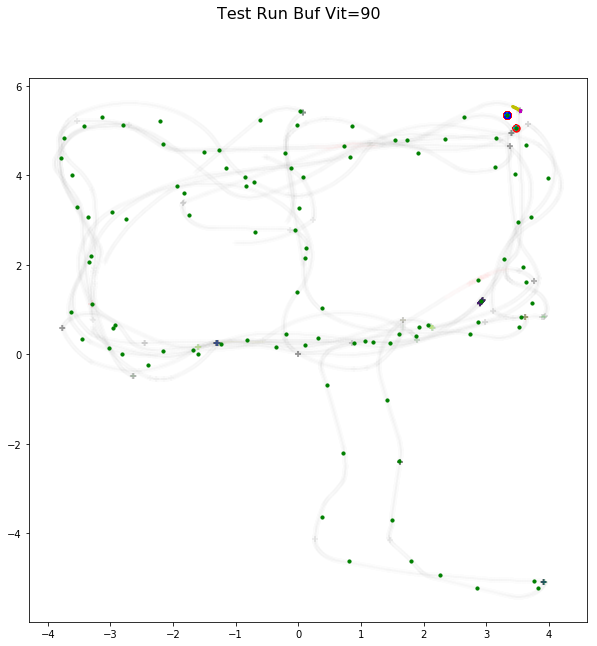

In [32]:
cc=ccxyth
paths= viterbi(obs_windowed,Modelo2,Modelo2.PI)
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=90', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.00313)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 , )
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52,alpha=.1 )
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='b' ,alpha=1)
ax1.scatter(x=cords1delay.xcuant, y=cords1delay.ycuant, marker='+',c='c' ,alpha=.1)



ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m')
cords3=path_to_xy(np.arange(0,Modelo1.A.shape[0]),cc)
ax1.scatter(x= cords3.xcuant, y=cords3.ycuant ,marker='.',s=40,c='g')



In [33]:



buf_vit=30
for i in range(1):
    
    
    obs_windowed= obs[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    path2= viterbi(obs_windowed,Modelo2,Modelo2.PI)
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat), accuracy(ytrue,yhat2))

1127
0.0 0.0


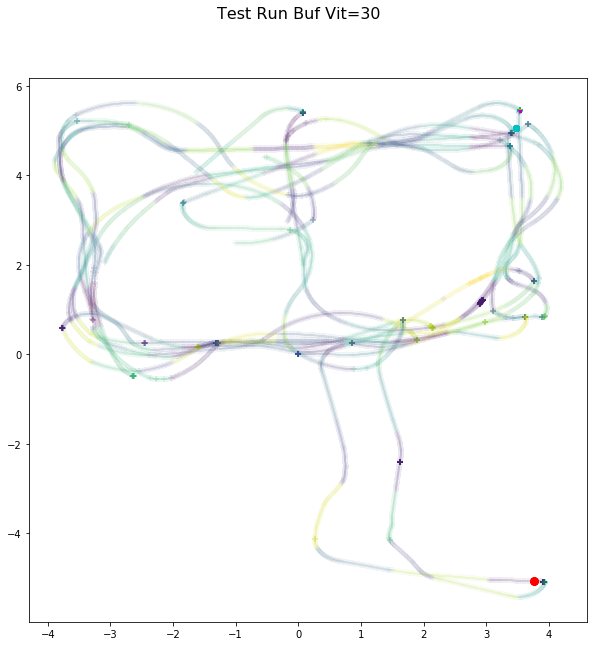

In [34]:
cc=ccxyth
paths= viterbi(obs_windowed,Modelo2,Modelo2.PI)
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=30', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52,alpha=.1 )
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='c' ,alpha=.5)
ax1.scatter(x=cords1delay.xcuant, y=cords1delay.ycuant, marker='+',c='c' ,alpha=.1)



ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m')



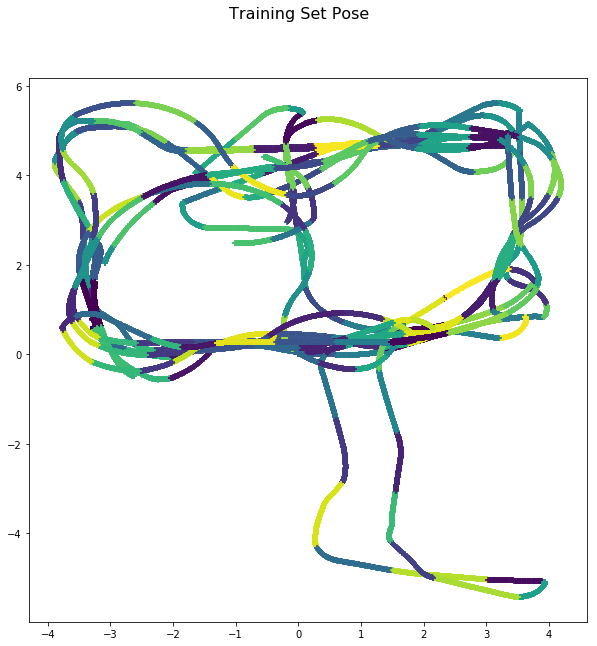

In [35]:


fig = plt.figure(figsize=(10,10))
fig.suptitle('Training Set Pose', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y)


In [36]:
nodes= ccxyth[:5,:]
conec=np.ones((len(nodes),5))*np.inf
conec[1,0],conec[0,1]=.3 , .3
conec[4,0],conec[0,4]=.7 , .7
conec[1,2],conec[2,1]=.1 , .1
conec[1,3],conec[3,1]=.3 , .3
conec[4,3],conec[3,4]=.2 , .2
graphe= grafo(nodes,conec )
graphe.conec

array([[inf, 0.3, inf, inf, 0.7],
       [0.3, inf, 0.1, 0.3, inf],
       [inf, 0.1, inf, inf, inf],
       [inf, 0.3, inf, inf, 0.2],
       [0.7, inf, inf, 0.2, inf]])

In [37]:
ruta=dijkstra(0,4,graphe)
ruta

RUTA CALCULADA 


[0.0, 4]

In [38]:
graphe= Markov_A_2_grafo(A,ccxyth)
graphe.conec[1,:]

array([       inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf, 0.87576509,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        

In [39]:

def Markov_A_2_grafo(A,ccxyth):
    dists=np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range (A.shape[1]):
            if A[i,j]!=0 :
                dists[i,j]= np.linalg.norm(ccxyth[i]-ccxyth[j])    
    
    
    con = np.where(dists==0,np.inf,dists)
    graphe2=grafo(ccxyth,con)
    return graphe2


In [40]:
graphe= Markov_A_2_grafo(A,ccxyth)
graphe.conec[1,:]

array([       inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf, 0.87576509,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        

In [41]:
nodoinicial=10
nodofinal=24
numnodos= len(graphe.nodos)
con = graphe.conec
D= np.ones(numnodos)*np.inf
Prv= np.ones(numnodos)*np.inf
V= np.zeros(numnodos)
a = nodoinicial
D[a]=0
Prv[a]=0
Prv[np.where(con[a]!=np.inf)]=a
V[a]=1
Dacc=D[a]
########
D=np.minimum(D,con[a]+D[a])
cont=0
sucess=False
while(sucess==False):
    a = np.argmin(D+np.where (V==1,np.inf, V))
    Dacc=D[a]
    Prv[np.where(D>(con[a]+Dacc) )]=a
    V[a]=1
    D=np.minimum(D,con[a]+Dacc)
    if (a== nodofinal):
        print("RUTA CALCULADA ")
        sucess=True
rutainv=[]
rutainv.append(nodofinal)
while(rutainv[-1]!=nodoinicial):
    prv=Prv[int(rutainv[-1])]
    rutainv.append(prv)
   
ruta=[]
for n in reversed(rutainv):
    ruta.append(n)


RUTA CALCULADA 


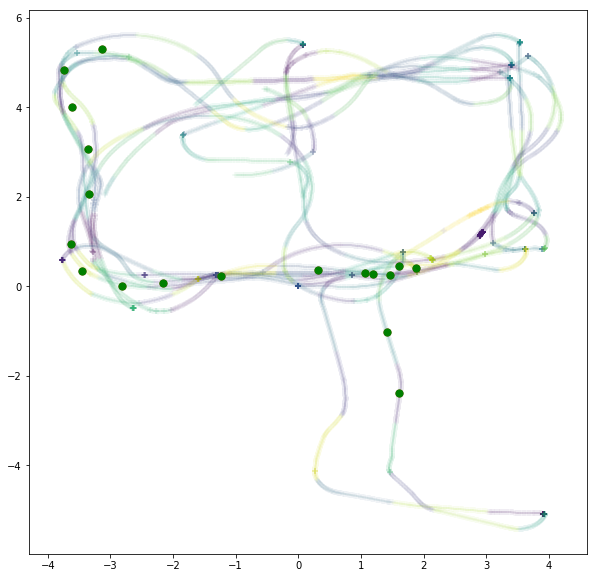

In [42]:
#ruta.append(nodofinal)
path=np.array(ruta)
path
cords_path= path_to_xy(path,cc)
#cords_path= path_to_xy(path[:int(len(path)/2)],cc)

cords_path2= path_to_xy(path,cc)



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords_path.xcuant, y=cords_path.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_path2.xcuant, y=cords_path2.ycuant, marker='o',c='g',s=52 )


In [43]:

def dijkstra(nodoinicial,nodofinal,graphe):

    numnodos= len(graphe.nodos)
    con = graphe.conec
    D= np.ones(numnodos)*np.inf
    Prv= np.ones(numnodos)*np.inf
    V= np.zeros(numnodos)
    a = nodoinicial
    D[a]=0
    Prv[a]=0
    Prv[np.where(con[a]!=np.inf)]=a
    V[a]=1
    Dacc=D[a]
    ########
    D=np.minimum(D,con[a]+D[a])
    cont=0
    sucess=False
    while(sucess==False):
        a = np.argmin(D+np.where (V==1,np.inf, V))
        Dacc=D[a]
        Prv[np.where(D>(con[a]+Dacc) )]=a
        V[a]=1
        D=np.minimum(D,con[a]+Dacc)
        if (a== nodofinal):
            print("RUTA CALCULADA ")
            sucess=True
    rutainv=[]
    rutainv.append(nodofinal)
    while(rutainv[-1]!=nodoinicial):
        prv=Prv[int(rutainv[-1])]
        rutainv.append(prv)

    ruta=[]
    for n in reversed(rutainv):
        ruta.append(n)
    return(ruta)


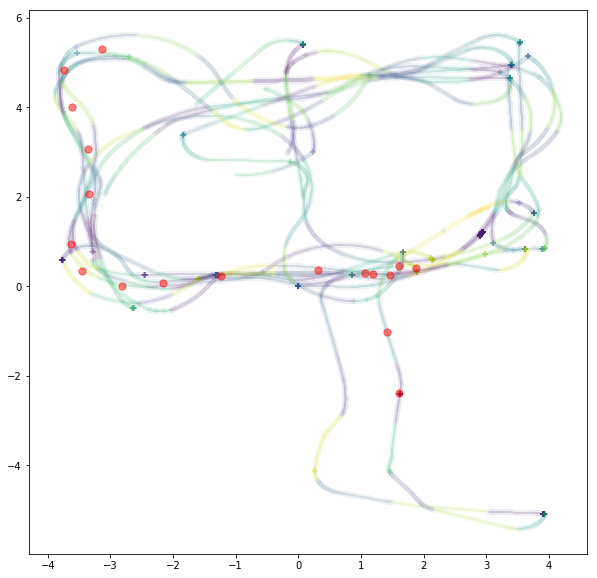

In [44]:
path=np.array(ruta)


cords_path= path_to_xy(path,cc)
#cords_path= path_to_xy(path[:int(len(path)/2)],cc)
#cords_path2= path_to_xy(path[int(len(path)/2):],cc)



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords_path.xcuant, y=cords_path.ycuant, marker='o',c='r',s=52,alpha=.5 )
#ax1.scatter(x=cords_path2.xcuant, y=cords_path2.ycuant, marker='o',c='g',s=52,alpha=.5 )

In [45]:
    N=20
    kmedias2=KMeans(n_clusters=N)
    kmedias2.fit(ccxyth)
    #est=kmedias2.labels_
    ccxyth_topo=kmedias2.cluster_centers_
    ccxyth=np.sort(ccxyth_topo,axis=0)


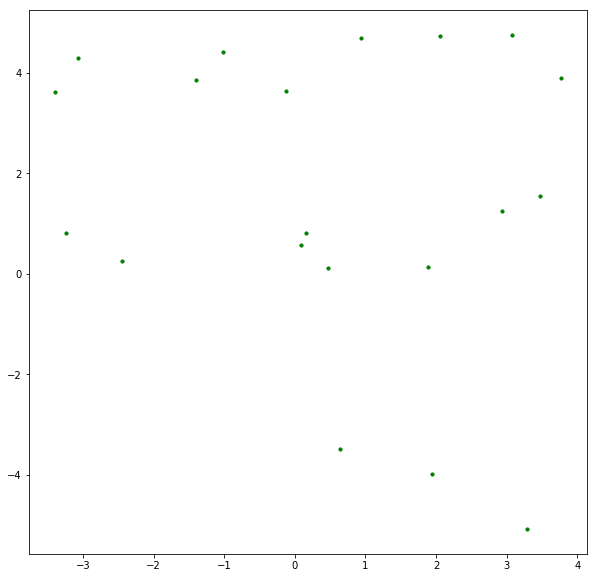

In [46]:
cc=ccxyth_topo



fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
cords3=path_to_xy(np.arange(0,20),cc)
ax1.scatter(x= cords3.xcuant, y=cords3.ycuant ,marker='.',s=40,c='g')



In [ ]:
a=0